In [20]:
'''
MacOS专用字体设置
MacOS 系统中使用的中文字体路径
适用于MacOS15版本
可直接复制到代码中使用
'''
import matplotlib.pyplot as plt
from matplotlib import font_manager
# 设置字体路径
font_path = '/System/Library/Fonts/STHeiti Medium.ttc'

# 加载字体
my_font = font_manager.FontProperties(fname=font_path)

# 设置为默认字体
plt.rcParams['font.family'] = my_font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

In [21]:
import pandas as pd

In [22]:
df = pd.read_excel('广告收益数据.xlsx')
df.head()


,电视,广播,报纸,收益
0,230.1,37.8,69.2,331.5
1,44.5,39.3,45.1,156.0
2,17.2,45.9,69.3,139.5
3,151.5,41.3,58.5,277.5
4,180.8,10.8,58.4,193.5


In [23]:
df.isnull().sum()

电视    0
广播    0
报纸    0
收益    0
dtype: int64

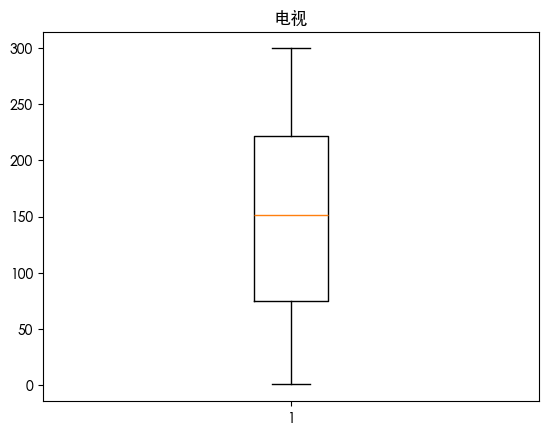

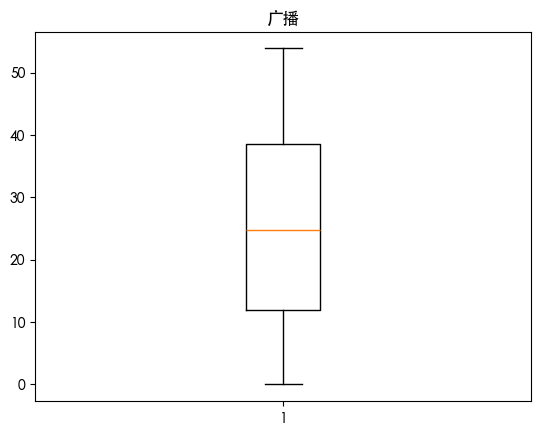

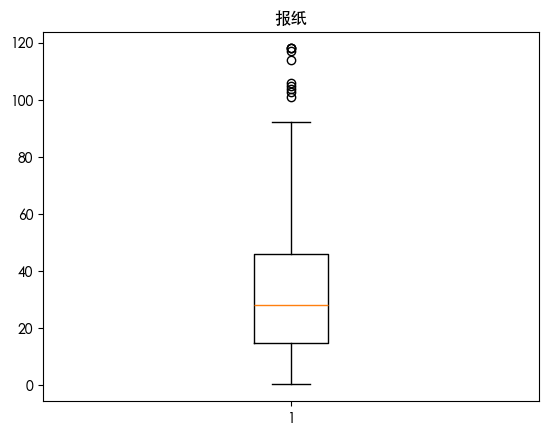

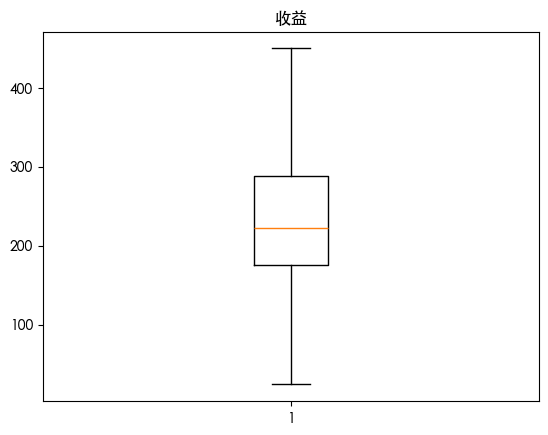

In [24]:
for col in df.columns:
    plt.boxplot(df[col])
    plt.title(col)
    plt.show()

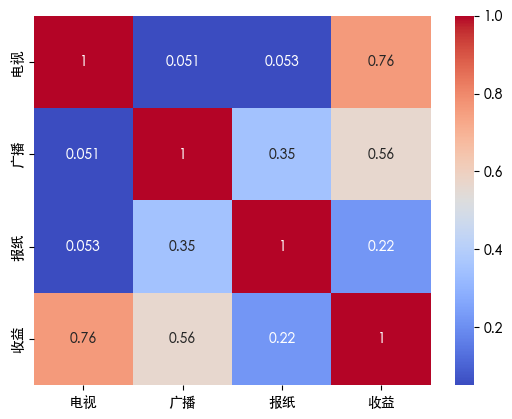

In [25]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [26]:
col = '报纸'

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df[f'{col}_is_outlier'] = ((df[col] < lower_bound) | (df[col] > upper_bound)).astype(int)

In [27]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['收益'])
y = df['收益']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost

In [28]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}')
print(f'R2: {r2}')


MSE: 297.3337115418742
R2: 0.9586054526363614


In [29]:
feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb.feature_importances_
}).sort_values(by="importance", ascending=False)
print(feature_importance)

         feature  importance
0             电视    0.561881
1             广播    0.412244
2             报纸    0.025875
3  报纸_is_outlier    0.000000


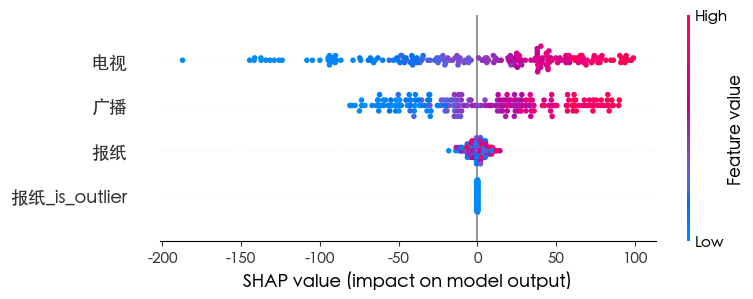

In [30]:
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

# LGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 745
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 3
[LightGBM] [Info] Start training from score 231.305625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

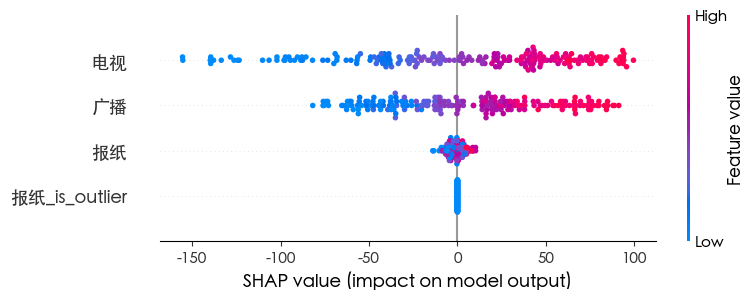

In [31]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
print(f'LGBM MSE: {mse_lgbm}')
print(f'LGBM R2: {r2_lgbm}')
feature_importance_lgbm = pd.DataFrame({
    "feature": X_train.columns,
    "importance": lgbm.feature_importances_
}).sort_values(by="importance", ascending=False)
print(feature_importance_lgbm)

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

# 随机森林

Random Forest MSE: 277.8198997774235
Random Forest R2: 0.961322148974425
         feature  importance
0             电视    0.624624
1             广播    0.356226
2             报纸    0.018884
3  报纸_is_outlier    0.000266


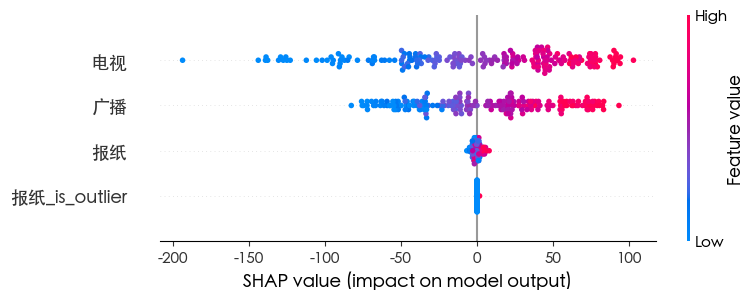

In [32]:
from sklearn.ensemble import RandomForestRegressor

rm = RandomForestRegressor(n_estimators=100, random_state=42)
rm.fit(X_train, y_train)
y_pred_rm = rm.predict(X_test)
mse_rm = mean_squared_error(y_test, y_pred_rm)
r2_rm = r2_score(y_test, y_pred_rm)
print(f'Random Forest MSE: {mse_rm}')
print(f'Random Forest R2: {r2_rm}')
feature_importance_rm = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rm.feature_importances_
}).sort_values(by="importance", ascending=False)
print(feature_importance_rm)

explainer = shap.TreeExplainer(rm)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

# SVM

SVR MSE: 2942.2258137398626
SVR R2: 0.5903858154199828


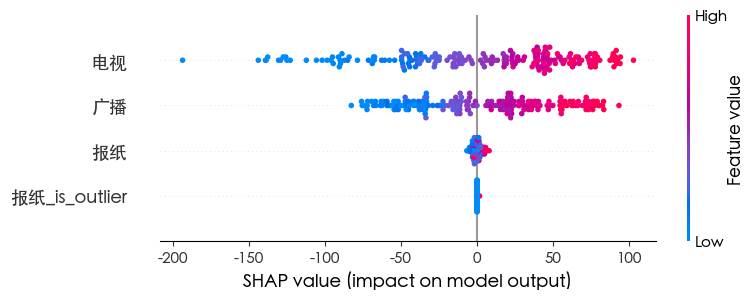

In [33]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print(f'SVR MSE: {mse_svr}')
print(f'SVR R2: {r2_svr}')


explainer = shap.TreeExplainer(rm)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

# KNN

In [34]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print(f'KNN MSE: {mse_knn}')
print(f'KNN R2: {r2_knn}')

KNN MSE: 423.61199999999997
KNN R2: 0.9410250963240132
